In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


input dataset shap:  (2893, 40, 32, 32)
output dataset shap:  (2893,)
gradient_type:  MG
device: cuda:0
Mean FR:  0.03347031218202218
epoch:   0, Train Loss: 2.2204, Train Acc: 0.1732,Valid Acc: 0.3253,fr: 0.0175
Mean FR:  0.03412178731928377
epoch:   1, Train Loss: 1.6001, Train Acc: 0.3916,Valid Acc: 0.4793,fr: 0.0355
Mean FR:  0.0384603654074928
epoch:   2, Train Loss: 1.2527, Train Acc: 0.5291,Valid Acc: 0.5849,fr: 0.0364
Mean FR:  0.038675211007585336
epoch:   3, Train Loss: 1.0978, Train Acc: 0.5929,Valid Acc: 0.6173,fr: 0.0379
Mean FR:  0.03985017072004469
epoch:   4, Train Loss: 0.9971, Train Acc: 0.6293,Valid Acc: 0.6505,fr: 0.0405
Mean FR:  0.04216368481435853
epoch:   5, Train Loss: 0.9251, Train Acc: 0.6600,Valid Acc: 0.6823,fr: 0.0412
Mean FR:  0.0422865303820404
epoch:   6, Train Loss: 0.8585, Train Acc: 0.6837,Valid Acc: 0.6952,fr: 0.0426
Mean FR:  0.04332042467861396
epoch:   7, Train Loss: 0.8239, Train Acc: 0.6989,Valid Acc: 0.7098,fr: 0.0431
Mean FR:  0.0447116543295

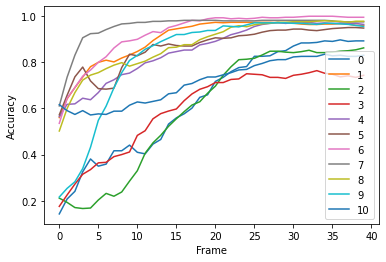

In [2]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import math
import matplotlib
from torch.utils import data

seq_length = 40
batch_size = 128
train_x = np.load('./data_set/train_x.npy')/255.
train_y = np.load('./data_set/train_y.npy')
# plt.hist(train_y)

valid_x = np.load('./data_set/valid_x.npy')/255.
valid_y = np.load('./data_set/valid_y.npy')

test_x = np.load('./data_set/test_x.npy')/255.
test_y = np.load('./data_set/test_y.npy')

# test_x = np.load('./data_set_ch/test_x_ch3.npy')/255.
# test_y = np.load('./data_set_ch/test_y_ch3.npy')
# remove the background images
idx_not_11 = np.where(test_y<11)[0]
test_x = test_x[idx_not_11,:,:,:]
test_y = test_y[idx_not_11]

_,seq_length,dim_row,dim_col = train_x.shape
print('input dataset shap: ',train_x.shape)
print('output dataset shap: ',train_y.shape)

def get_DataLoader(train_x,train_y,batch_size=200,is_binary=False):
    train_y = np.tile(train_y,seq_length).reshape(seq_length,len(train_y)).T
    if is_binary:
        train_dataset = data.TensorDataset(torch.Tensor((train_x>0)*1.), torch.Tensor(train_y))
    else:
        train_dataset = data.TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

train_loader = get_DataLoader(train_x,train_y,batch_size=batch_size)
test_loader = get_DataLoader(test_x,test_y,batch_size=batch_size)
valid_loader = get_DataLoader(valid_x,valid_y,batch_size=batch_size)

torch.manual_seed(40)
thresh = 0.5  # neuronal threshold
b_j0 = 0.1  # neural threshold baseline
R_m = 1  # membrane resistance
lens = 0.3
gamma = 0.5

gradient_type = 'MG'
print('gradient_type: ',gradient_type)
def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


# define approximate firing function

class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.#4.0
        hight = .15#0.25#.15
        if gradient_type == 'G':
            temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        elif gradient_type == 'MG':
            temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
                - gaussian(input, mu=lens, sigma=scale * lens) * hight \
                - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        elif gradient_type =='linear':
            temp = F.relu(1-input.abs())
        elif gradient_type == 'slayer':
            temp = torch.exp(-5*input.abs())
        return grad_input * temp.float() * gamma


act_fun_adp = ActFun_adp.apply


def mem_update_adp(inputs, mem, spike, tau_adp, b, tau_m, dt=1, isAdapt=1):
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    ro = torch.exp(-1. * dt / tau_adp).cuda()
    if isAdapt:
        beta = 1.84
    else:
        beta = 0.

    b = ro * b + (1 - ro) * spike
    B = b_j0 + beta * b

    mem = mem * alpha + (1 - alpha) * R_m * inputs - B * spike * dt
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    return mem, spike, B, b

def output_Neuron(inputs, mem, tau_m, dt=1):
    """
    The read out neuron is leaky integrator without spike
    """
    alpha = torch.exp(-1. * dt / tau_m)
    mem = mem *alpha +  (1-alpha)*inputs
    return mem

    
class RNN_s(nn.Module):
    def __init__(self, sub_seq_length,criterion):
        super(RNN_s, self).__init__()
        self.criterion = criterion
        self.sub_seq_length = sub_seq_length

        self.n  =512
        self.dense_i = nn.Linear(1024,self.n)
        self.dense_i2r = nn.Linear(self.n,self.n)
        self.dense_r = nn.Linear(self.n,self.n)
        self.dense_o = nn.Linear(self.n,11)
        
        self.tau_adp_i = nn.Parameter(torch.Tensor(self.n))
        self.tau_adp_r = nn.Parameter(torch.Tensor(self.n))
        self.tau_adp_o = nn.Parameter(torch.Tensor(11))
        
        self.tau_m_i = nn.Parameter(torch.Tensor(self.n))
        self.tau_m_r = nn.Parameter(torch.Tensor(self.n))
        self.tau_m_o = nn.Parameter(torch.Tensor(11))

        nn.init.orthogonal_(self.dense_r.weight)
        nn.init.xavier_uniform_(self.dense_i.weight)
        nn.init.xavier_uniform_(self.dense_i2r.weight)
      
        nn.init.constant_(self.dense_i.bias, 0)
        nn.init.constant_(self.dense_r.bias, 0)
        
        nn.init.normal_(self.tau_adp_i,20,5)
        nn.init.normal_(self.tau_adp_r,20,5)
        nn.init.normal_(self.tau_adp_o,10,5)
        
        nn.init.normal_(self.tau_m_i,20,5)
        nn.init.normal_(self.tau_m_r,20,5)
        nn.init.normal_(self.tau_m_o,3,1)

        # nn.init.constant_(self.tau_adp_i,20)
        # nn.init.constant_(self.tau_adp_r,20)
        # nn.init.constant_(self.tau_adp_o,10)
        
        # nn.init.constant_(self.tau_m_i,20)
        # nn.init.constant_(self.tau_m_r,20)
        # nn.init.constant_(self.tau_m_o,3)
        
        self.b_h = self.b_o = b_j0

    def forward(self, input,labels=None,sub_length =5,output_type='integrator'):
        b,s,l = input.shape
        mem_layer1 = spike_layer1 = torch.rand(b, self.n).cuda()
        mem_layer2 = spike_layer2 = torch.rand(b, self.n).cuda()
        mem_layer3 = spike_layer3 = mem_output = torch.rand(b, 11).cuda()
        self.b_i = self.b_o=self.b_r = b_j0
        output = torch.zeros(b, 11).cuda()
        loss = 0
        predictions = []
        spike1_list = []
        spike2_list = []
        fr = []
        for i in range(s):
            input_x=input[:,i,:]
            d1_output = self.dense_i(input_x)
            mem_layer1, spike_layer1, theta_i, self.b_i = mem_update_adp(d1_output, mem_layer1, spike_layer1, self.tau_adp_i, self.b_i,self.tau_m_i)
            r_input = self.dense_i2r(spike_layer1)+self.dense_r(spike_layer2)
            mem_layer2, spike_layer2, theta_r, self.b_r = mem_update_adp(r_input, mem_layer2, spike_layer2, self.tau_adp_r, self.b_r,self.tau_m_r)
            o_input = self.dense_o(spike_layer2)
            if output_type == 'adp-mem':
                mem_layer3, spike_layer3, theta_o, self.b_o = mem_update_adp(o_input, mem_layer3, spike_layer3, self.tau_adp_o, self.b_o,self.tau_m_o)
            elif output_type == 'integrator':
                mem_layer3 = output_Neuron(o_input, mem_layer3, self.tau_m_o)
            
            output = F.log_softmax(mem_layer3,dim=-1)#
            
            # output_  = F.log_softmax(output,dim=1)
            predictions.append(output.data.cpu().numpy())
            if labels is not None:
                loss += self.criterion(output, labels[:, i])
                # if i > 30:
                #     loss += self.criterion(output, labels[:, i])*(1+(i-30)/30.)
                # else:
                #     loss += self.criterion(output, labels[:, i])
            
            fr.append((spike_layer1.detach().mean().cpu().numpy()+spike_layer2.detach().mean().cpu().numpy())/2.)
            spike1_list.append(spike_layer1.detach().cpu().numpy())
            spike2_list.append(spike_layer2.detach().cpu().numpy())
        predictions = torch.tensor(predictions)
        return predictions, loss,np.mean(fr),[spike1_list,spike2_list]

    def predict(self,input):
        prediction, _= self.forward(input)
        return prediction
    
def test(data_loader,after_num_frames=0):
    test_acc = 0.
    sum_samples = 0
    fr_list = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.view(-1, seq_length, 1024).to(device)
        labels = labels.view((-1,seq_length)).long().to(device)
        predictions, _,fr,_ = model(images)
        _, predicted = torch.max(predictions.data, 2)
        labels = labels.cpu()
        predicted = predicted.cpu().t()
        fr_list.append(fr)
        
        test_acc += (predicted[:,after_num_frames:] == labels[:,after_num_frames:]).sum()
        
        sum_samples = sum_samples + predicted.numel()
    print('Mean FR: ',np.mean(fr_list))
    return test_acc.data.cpu().numpy() / sum_samples

def test_frame(data_loader,after_num_frames=0):
    test_acc = 0.
    sum_samples = 0
    test_acc_classes = np.zeros((11,40))
    test_acc_count = np.zeros((11,1))                                       
    fr_list = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.view(-1, seq_length, 1024).to(device)
        labels = labels.view((-1,seq_length)).long().to(device)
        predictions, _,fr,_ = model(images)
        _, predicted = torch.max(predictions.data, 2)
        labels = labels.cpu()
        predicted = predicted.cpu().t()
        fr_list.append(fr)
        
        test_acc += (predicted[:,after_num_frames:] == labels[:,after_num_frames:]).float().mean(axis=0)
        f_test = predicted[:,after_num_frames:] == labels[:,after_num_frames:]
        for i in range(f_test.shape[0]):
            tmp = labels[i,0]
            test_acc_classes[tmp] += f_test[i].float().cpu().numpy()
            test_acc_count[tmp] += 1
        if i==1:
            print(f_test.shape)
        
        sum_samples = sum_samples + predicted.numel()
    print('Mean FR: ',np.mean(fr_list))

    return test_acc.data.cpu().numpy() / i,test_acc_classes/test_acc_count

def train(model,loader,optimizer,scheduler=None,num_epochs=10):
    best_acc = 0
    path = 'model/'  # .pth'
    acc_list=[]
    for epoch in range(num_epochs):
        train_acc = 0
        train_loss_sum = 0
        sum_samples = 0
        fr_list = []
        for i, (images, labels) in enumerate(loader):
            images = images.view(-1, seq_length, 1024).requires_grad_().to(device)#images.view(-1, num_samples, input_dim).requires_grad_().to(device)
            labels = labels.view((-1,seq_length)).long().to(device)
            optimizer.zero_grad()
            
            predictions, train_loss,fr_,stats = model(images, labels)
            _, predicted = torch.max(predictions.data, 2)
            
            train_loss.backward()#retain_graph=True)
            train_loss_sum += train_loss
            fr_list.append(fr_)
            optimizer.step()

            labels = labels.cpu()
            predicted = predicted.cpu().t()
            train_acc += (predicted == labels).sum()
            sum_samples = sum_samples + predicted.numel()
    
        if scheduler is not None:
            scheduler.step()
            
        train_acc = train_acc.data.cpu().numpy() / sum_samples
        valid_acc = test(valid_loader)
        
        if valid_acc>best_acc and train_acc>0.80:
            best_acc = valid_acc
            torch.save(model, path+str(best_acc)[:5]+'-frame-vis-fin.pth')

        acc_list.append(train_acc)
        print('epoch: {:3d}, Train Loss: {:.4f}, Train Acc: {:.4f},Valid Acc: {:.4f},fr: {:.4f}'.format(epoch,
                                                                           train_loss_sum.item()/len(loader)/(seq_length),
                                                                           train_acc,valid_acc,np.mean(fr_list)), flush=True)
    return acc_list


num_epochs = 80
sub_seq_length = 10
criterion = nn.NLLLoss()#nn.CrossEntropyLoss()
model = RNN_s(sub_seq_length=sub_seq_length,criterion=criterion)
# model.load('./model/796-mem.pth')
# model.load_state_dict(torch.load('./model/0.766-frame.pth'))
# model = torch.load('./model/0.826-frame-v3-inte-256.pth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)
model.to(device)

learning_rate =1.5e-2#1e-2

base_params = [model.dense_i.weight, model.dense_i.bias, 
               model.dense_o.weight, model.dense_o.bias,
               model.dense_r.weight, model.dense_r.bias, 
               model.dense_i2r.weight, model.dense_i2r.bias]
optimizer = torch.optim.Adam([
    {'params': base_params},
    {'params': model.tau_adp_i, 'lr': learning_rate * 5},
    {'params': model.tau_adp_r, 'lr': learning_rate * 5},
    {'params': model.tau_adp_o, 'lr': learning_rate * 5},
    {'params': model.tau_m_i, 'lr': learning_rate * 2.5},
    {'params': model.tau_m_r, 'lr': learning_rate * 2.5},
    {'params': model.tau_m_o, 'lr': learning_rate * 2.5}],
    lr=learning_rate)


scheduler = StepLR(optimizer, step_size=30, gamma=.5) 

# training network

# with sechdual
train_acc_list = train(model,train_loader,optimizer,scheduler,num_epochs=num_epochs)
test_acc = test(test_loader)
print(test_acc)

test_acc = test(test_loader,10)
print(test_acc/30*40.)

test_acc = test(test_loader,20)
print(test_acc/20.*40.)

test_acc,test_acc_classes = test_frame(test_loader)
print(test_acc)
print('last frame',np.mean(test_acc_classes[:,-1]),test_acc_classes[:,-1])
print(test_acc_classes.shape)

for i in range(11):
    plt.plot(test_acc_classes[i],label=str(i))
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Accuracy')
plt.show()

# plt.plot(test_acc)
# plt.xlabel('Frame')
# plt.ylabel('Accuracy')
# plt.show()


In [3]:
fr_list = []
for i, (images, labels) in enumerate(test_loader):
    if i ==0:
        images = images.view(-1, seq_length, 1024).to(device)
        labels = labels.view((-1,seq_length)).long().to(device)
        predictions, _,fr,states = model(images)
        _, predicted = torch.max(predictions.data, 2)
        labels = labels.cpu()
        predicted = predicted.cpu().t()
        fr_list.append(fr)
    else:
        break

In [4]:
spike1,spike2 = states

In [5]:
spike1_np = np.array(spike1)
spike2_np = np.array(spike2)
spike1_np.shape,spike2_np.shape
_,b,_ = spike1_np.shape
spikes = np.zeros((40,b,1024))
spikes[:,:,:512] = spike1_np
spikes[:,:,512:] = spike2_np


In [6]:
spike_count = {'total':[],'fr':[],'per step':[]}
spike_count['total'].append([np.mean(np.sum(spikes,axis=(0,2))),np.max(np.sum(spikes,axis=(0,2))),np.min(np.sum(spikes,axis=(0,2)))])
spike_count['fr'].append(np.mean(spikes))
spike_count['per step'].append([np.mean(np.sum(spikes,axis=(2))),np.max(np.sum(spikes,axis=(2))),np.min(np.sum(spikes,axis=(2)))])

In [7]:
spike_count

{'total': [[2521.4609375, 4179.0, 1472.0]],
 'fr': [0.061559104919433595],
 'per step': [[63.0365234375, 338.0, 8.0]]}

In [8]:
spike_count = {'total':[],'fr':[],'per step':[]}
for i, (images, labels) in enumerate(test_loader):
    images = images.view(-1, seq_length, 1024).to(device)
    labels = labels.view((-1,seq_length)).long().to(device)
    predictions, _,fr,states = model(images)

    spike1,spike2 = states
    spike1_np = np.array(spike1)
    spike2_np = np.array(spike2)
    spike1_np.shape,spike2_np.shape
    _,b,_ = spike1_np.shape
    spikes = np.zeros((40,b,1024))
    spikes[:,:,:512] = spike1_np
    spikes[:,:,512:] = spike2_np
    spike_count['total'].append([np.mean(np.sum(spikes,axis=(0,2))),np.max(np.sum(spikes,axis=(0,2))),np.min(np.sum(spikes,axis=(0,2)))])
    spike_count['fr'].append(np.mean(spikes))
    spike_count['per step'].append([np.mean(np.sum(spikes,axis=(2))),np.max(np.sum(spikes,axis=(2))),np.min(np.sum(spikes,axis=(2)))])

In [9]:
spike_total = np.array(spike_count['total'])
spike_total.shape

(40, 3)

In [10]:
np.mean(spike_total[0]),np.max(spike_total[1]),np.min(spike_total[2])

(2629.5104166666665, 4145.0, 1586.0)

In [11]:
spike_per = np.array(spike_count['per step'])
np.mean(spike_per[0]),np.max(spike_per[1]),np.min(spike_per[2])

(116.69609375, 289.0, 6.0)

In [12]:
spike_fr = np.array(spike_count['fr'])
np.mean(spike_fr)

0.06052846717834472